1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) 1 балл

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) 1 балла

*3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) 0.5 балл*

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд,лучший результат показал лучший алгоритм 1 балл

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) 1,5 балла

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords, words
STOPWORDS = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, RidgeCV, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Price prediction

In [2]:
def clean_description(desc):
  for ps in string.punctuation:
    desc = desc.replace(ps, '')
  desc = re.sub(r'\d*', '', desc)
  desc = desc.lower()
  desc = ''.join(filter(lambda x: x in string.printable, desc))
  clean_words = []
  for w in desc.split():
    if w not in STOPWORDS:
      clean_words.append(w)
  out = lemmatize(' '.join(clean_words))
  if out:
    if out == 'report abuse':
      return np.nan
    elif out == 'verified purchase':
      return np.nan
    else:
      return out
  else:
    return np.nan
  

def norm(df):
  return (df-df.min())/(df.max()-df.min())


def clean_normalize_price(ser):
  ser = ser.apply(lambda x: x.replace('₹', ''))
  ser = ser.apply(float).apply(int)
  return norm(ser)


def lemmatize(x):
  wordnet_lemmatizer = WordNetLemmatizer()
  tokenization = nltk.word_tokenize(x)
  return ' '.join([wordnet_lemmatizer.lemmatize(w) for w in tokenization])


def prepare_data_frame(df):
  df_out = pd.DataFrame()
  df_out['price_value'] = df['price_value'].str.replace('₹', '').apply(float).apply(int)
  df_out['product_description'] = df['product_description'].apply(clean_description)
  df_out['price'] = clean_normalize_price(df['price'])
  return df_out


In [3]:
data = pd.read_csv('Shoes_Data.csv')
price_df = data[['product_description', 'price']]
price_df['price_value'] = price_df['price']
price_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,product_description,price,price_value
0,Elevate your style with this classy pair of Ru...,₹279.00,₹279.00
1,The product will be an excellent pick for you....,₹479.00,₹479.00
2,Flaunt with these stylish and unique red casua...,₹430.00,₹430.00
3,Robbie Jones Shoes Are Designed To Keeping In ...,₹499.00,₹499.00
4,Sparx is a spectacular range of footwear from ...,₹499.00,₹499.00
...,...,...,...
1225,The Nike react vision is a STORY of surreal co...,₹7256.00,₹7256.00
1226,The B.O.G limitless is Puma's key style for th...,₹5822.00,₹5822.00
1227,Lead the pack in New Balance’s Echolucent snea...,₹5362.00,₹5362.00
1228,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,₹7480.00,₹7480.00


## Подготовим датафрейм
Уберем странные символы, почистим пунктуацию, лемматизируем 

Нормализируем цену от 0 до 1 ради одинаковой размерности таргета



In [4]:
price_df = prepare_data_frame(price_df).dropna()
price_df

,price_value,product_description,price
0,279,elevate style classy pair running shoe house c...,0.019326
1,479,product excellent pick ensures easy maintenance,0.044755
2,430,flaunt stylish unique red casual shoe per late...,0.038525
3,499,robbie jones shoe designed keeping mind durabi...,0.047298
4,499,sparx spectacular range footwear house relaxo ...,0.047298
...,...,...,...
1225,7256,nike react vision story surreal comfort layere...,0.906421
1226,5822,bog limitless puma key style new season inspir...,0.724094
1227,5362,lead pack new balance echolucent sneaker sneak...,0.665607
1228,7480,nike k nike woman running shoe feel even look ...,0.934901


## Данные

In [5]:
price_df.describe()

,price_value,price
count,1227.000000,1227.000000
mean,2024.590872,0.241270
std,1721.980165,0.218942
min,127.000000,0.000000
25%,620.500000,0.062746
50%,1580.000000,0.184743
75%,2831.000000,0.343802
max,7992.000000,1.000000


У нас достаточно много выбросов (и мало данных)

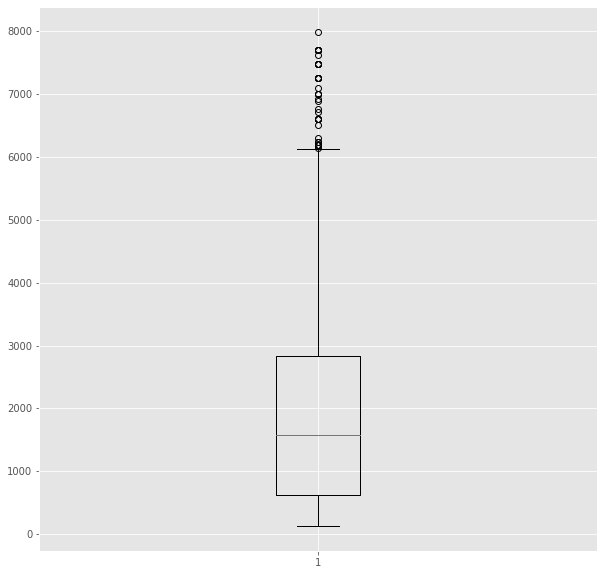

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.boxplot(price_df['price_value'])
plt.show()

Поделим выборку на трейн и тест

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    price_df['product_description'],
    price_df['price'], 
    train_size=0.8, 
    test_size=0.2, 
    random_state=228)

## Модели

Я использовал пайплайны (очень удобно) для гридсерча по моделям

Попробуем разные векторизации для RidgeCV

В качестве скоринга будем использовать R2 (коеффицент детерминации)


In [8]:
pipeline = Pipeline([('vec', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', RidgeCV(gcv_mode='auto'))])

parameters = {'vec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__normalize': (True, False)
              }
               
ridgecv_cv = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "r2")
ridgecv_cv = ridgecv_cv.fit(X_train, y_train)
print('Best params: ', ridgecv_cv.best_params_)
preds = ridgecv_cv.predict(X_test)
print('R2 score: ', r2_score(preds, y_test))
print('MAE score: ', mean_absolute_error(preds, y_test))
print('RMSE score: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'reg__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vec__ngram_range': (1, 3)}
R2 score:  0.6660447283752144
MAE score:  0.06438829773956764
RMSE score:  0.11012801630544752


In [9]:
pipeline = Pipeline([('vec', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', RidgeCV(gcv_mode='auto'))])

parameters = {'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__normalize': (True, False)
              }
               
ridgecv_tfidf = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "r2")
ridgecv_tfidf = ridgecv_tfidf.fit(X_train, y_train)
print('Best params: ', ridgecv_tfidf.best_params_)
preds = ridgecv_tfidf.predict(X_test)
print('R2 score: ', r2_score(preds, y_test))
print('MAE score: ', mean_absolute_error(preds, y_test))
print('RMSE score: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'reg__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True}
R2 score:  0.6064345471641764
MAE score:  0.06995770902563611
RMSE score:  0.12012572972039161


In [10]:
pipeline = Pipeline([('vec', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', LinearRegression())])

parameters = {'vec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__normalize': (True, False)}
               
linreg_cv = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "r2")
linreg_cv = linreg_cv.fit(X_train, y_train)
print('Best params: ', linreg_cv.best_params_)
preds = linreg_cv.predict(X_test)
print('R2 score: ', r2_score(preds, y_test))
print('MAE score: ', mean_absolute_error(preds, y_test))
print('RMSE score: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'reg__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True, 'vec__ngram_range': (2, 3)}
R2 score:  0.6018306070707805
MAE score:  0.06764319167666595
RMSE score:  0.1230406357038957


In [11]:
pipeline = Pipeline([('vec', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('reg', LinearRegression())])

parameters = {
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'reg__normalize': (True, False)}
               
linreg_tfidf = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "r2")
linreg_tfidf = linreg_tfidf.fit(X_train, y_train)
print('Best params: ', linreg_tfidf.best_params_)
preds = linreg_tfidf.predict(X_test)
print('R2 score: ', r2_score(preds, y_test))
print('MAE score: ', mean_absolute_error(preds, y_test))
print('RMSE score: ', np.sqrt(mean_squared_error(y_test, preds)))

Best params:  {'reg__normalize': True, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': True}
R2 score:  0.05715944042440513
MAE score:  0.23193613100314867
RMSE score:  0.4524866198746389


Лучше всего показал себя RidgeCV + CountVectorizer (судя по коеффиценту детерминации R2 score и explained_variance_score)

In [13]:
preds = ridgecv_cv.predict(X_test)
explained_variance_score(y_test, preds)

0.744102975620909

## Что делать?

Было бы круто сделать дополнительные фичи и анализировать, например, бренд: например, кроссовки от луи виттон будут стоить обычно дороже, чем какой-нибудь демикс. Возможно еще важен пол, не уверен. 

Также стоит почистить данные от выбросов

# Rating prediction


In [14]:
def prepare_data_rating(df):
  all_reviews = df['reviews'].str.split(pat="\|\| ", expand=True).stack().reset_index(drop=True)
  all_ratings = df['reviews_rating'].str.split(pat="\|\| ", expand=True).stack().reset_index(drop=True)
  out_df = pd.DataFrame()
  out_df['review'] = all_reviews.apply(clean_description).dropna()
  out_df['reviews_rating'] = all_ratings.apply(get_rating)
  return out_df

def get_rating(x):
  return str(x)[0]

## Подготовим датафрейм

Сделаем то же самое, что и с описанием

In [15]:
raw_rating = data[['reviews', 'reviews_rating']]
rating_df = prepare_data_rating(raw_rating)
rating_df = rating_df.dropna()
rating_df

,review,reviews_rating
0,happy product,1
1,expected,1
2,average product,3
3,pic beautiful,3
4,got damage product quality average,3
...,...,...
9953,go,5
9954,excellent product,5
9955,nice shoe,5
9956,nice,5


## Данные

Посмотрим распределение классов в датафрейме

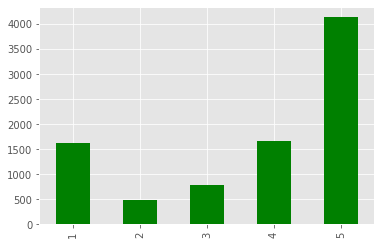

In [16]:
rating_df['reviews_rating'].value_counts().sort_index().plot.bar(color='green')

Есть сильный дисбаланс классов. Это не очень хорошо для классификации

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    rating_df['review'], 
    rating_df['reviews_rating'], 
    train_size=0.8, 
    test_size=0.2, 
    random_state=228)

## Модели

Попробуем разную векторизацию для MultinomialNB

Для скоринга будем использовать F1 weighted из-за дизбаланса классов

In [18]:
pipeline = Pipeline([('vec', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB())])

parameters = {'vec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__alpha': (10, 1, 0.1, 0.01)}
               
mnb_cv = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "f1_weighted")
mnb_cv = mnb_cv.fit(X_train, y_train)

print('Best params: ', mnb_cv.best_params_)
preds = mnb_cv.predict(X_test)
print('F1 weighted score: ', f1_score(preds, y_test, average='weighted'))

Best params:  {'clf__alpha': 0.01, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False, 'vec__ngram_range': (1, 3)}
F1 weighted score:  0.6941092469492488


In [19]:
pipeline = Pipeline([('vec', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB())])

parameters = {'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__alpha': (10, 1, 0.1, 0.01)}
               
mnb_tfidf = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "f1_weighted")
mnb_tfidf = mnb_tfidf.fit(X_train, y_train)

print('Best params: ', mnb_tfidf.best_params_)
preds = mnb_tfidf.predict(X_test)
print('F1 weighted score: ', f1_score(preds, y_test, average='weighted'))

Best params:  {'clf__alpha': 0.1, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False}
F1 weighted score:  0.6889615289986194


In [20]:
pipeline = Pipeline([('vec', TfidfVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', LogisticRegression())])

parameters = {
              'tfidf__use_idf': (True, False),
              'tfidf__smooth_idf': (True, False),
              'tfidf__sublinear_tf': (True, False),
              'clf__penalty': ('l1', 'l2', 'elasticnet', 'none'),
              'clf__class_weight': ('balanced', None),
              'clf__max_iter': (100, 1000)}
               
logreg_tfidf = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "f1_weighted")
logreg_tfidf = logreg_tfidf.fit(X_train, y_train)

print('Best params: ', logreg_tfidf.best_params_)
preds = logreg_tfidf.predict(X_test)
print('F1 weighted score: ', f1_score(preds, y_test, average='weighted'))

Best params:  {'clf__class_weight': None, 'clf__max_iter': 100, 'clf__penalty': 'none', 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__use_idf': False}
F1 weighted score:  0.6637644286894793


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
pipeline = Pipeline([('vec', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', LogisticRegression())])

parameters = {'vec__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
              'tfidf__use_idf': (True, False),
              'tfidf__smooth_idf': (True, False),
              'tfidf__sublinear_tf': (True, False),
              'clf__penalty': ('l1', 'l2', 'elasticnet', 'none'),
              'clf__class_weight': ('balanced', None),
              'clf__max_iter': (100, 1000)}
               
logreg_cv = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = "f1_weighted")
logreg_cv = logreg_cv.fit(X_train, y_train)

print('Best params: ', logreg_cv.best_params_)
preds = logreg_cv.predict(X_test)
print('F1 weighted score: ', f1_score(preds, y_test, average='weighted'))

KeyboardInterrupt: ignored

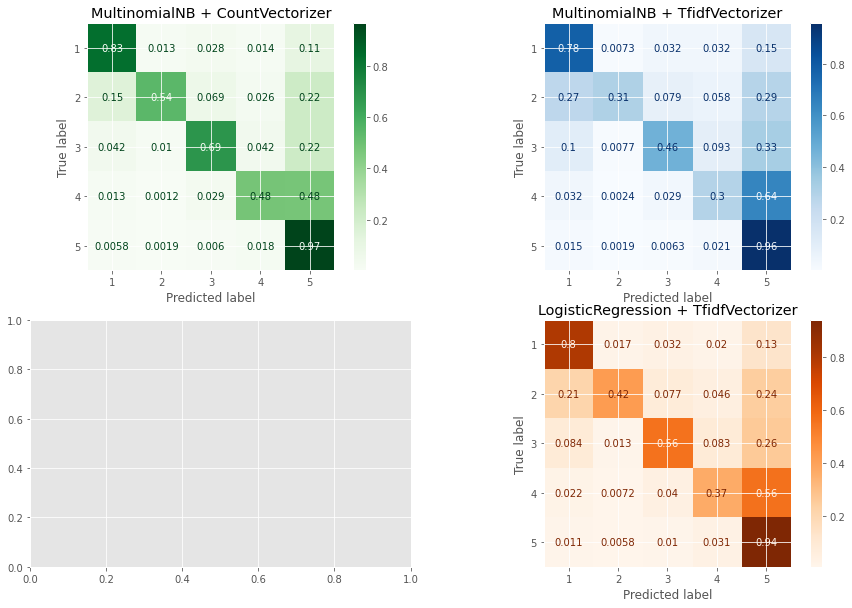

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10)) 
plot_confusion_matrix(mnb_cv,
                             rating_df['review'],
                             rating_df['reviews_rating'],
                             normalize='true',
                             cmap='Greens',
                             ax=axs[0][0])
plot_confusion_matrix(mnb_tfidf,
                             rating_df['review'],
                             rating_df['reviews_rating'],
                             normalize='true',
                             cmap='Blues',
                             ax=axs[0][1])

# слишком долго обучалась, пришлось опустить
#plot_confusion_matrix(logreg_cv,
                             #rating_df['review'],
                             #rating_df['reviews_rating'],
                             #normalize='true',
                             #cmap='Reds',
                             #ax=axs[1][0])
plot_confusion_matrix(logreg_tfidf,
                             rating_df['review'],
                             rating_df['reviews_rating'],
                             normalize='true',
                             cmap='Oranges',
                             ax=axs[1][1])


axs[0][0].set_title('MultinomialNB + CountVectorizer')
axs[0][1].set_title('MultinomialNB + TfidfVectorizer')
#axs[1][0].set_title('LogisticRegression + CountVectorizer')
axs[1][1].set_title('LogisticRegression + TfidfVectorizer')
plt.show()

Видимо, из-за дизбаланса классов оценки 2-3-4 иногда предсказываются как 5

Лучшая моделль MultinomialNB + Countvectorizer, однако она путает 5 и 4. Видимо, они достаточно похожи. Решается увеличением данных

## Что делать?

В первую очередь надо разобраться с дисбалансом классов (upsampling, расширить классы например добавить примеров, использовать контекстуаьные эмбеддинги типа w2v для замены на синонимы итд.)

